In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)
from shapely import geometry
import pointpats
import shapely

from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.objectives import *
from sgptools.methods import get_method
from sgptools.kernels import get_kernel
from sgptools.kernels.attentive import *
from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import Dataset

np.random.seed(1234)
tf.random.set_seed(1234)

/home/itskalvik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-11-18 09:58:57.407725: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 09:58:57.429450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 09:58:57.599031: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-18 09:58:57.732348: E ex

In [2]:
# Method to extract lengthscales map from attentive non stationary kernel
def predict_lengthscales(X, lengthscales, kernel):
        preds = np.zeros(len(X))
        repre1 = kernel.get_representations(X)
        for i in range(len(lengthscales)):
                attention = tf.tensordot(repre1[:, i],
                                         tf.transpose(repre1[:, i]),
                                         axes=0)
                preds += np.diag(attention) * lengthscales[i]
        return preds

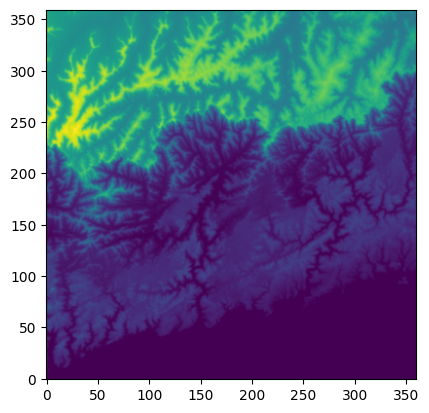

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-11-18 09:59:07.078875: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()
lengthscales = np.linspace(1, 10, 10)

# Train GP/Kernel 
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(lengthscales=lengthscales),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

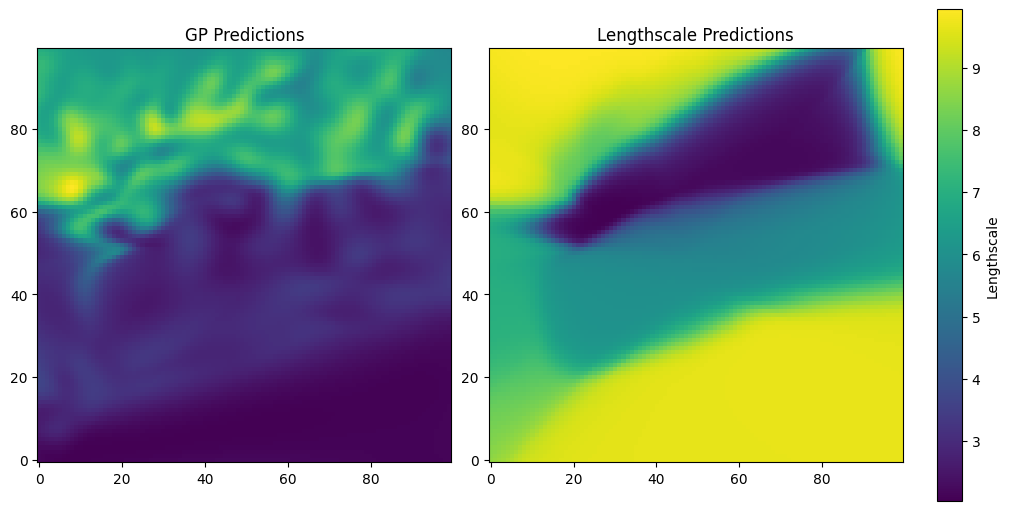

In [4]:
# Plot GP prediction and lengthscale map
X_test, _ = dataset.get_test()
grid_x, grid_y = np.mgrid[min(X_test[:, 0]):max(X_test[:, 0]):100j, 
                          min(X_test[:, 1]):max(X_test[:, 1]):100j]
X_test = np.stack([grid_x, grid_y], axis=-1)
x_dim, y_dim = X_test.shape[:2]
X_test = X_test.reshape(-1, 2).astype(X_train.dtype)

mean, std = model.predict_f(X_test)
lengthscale_preds = predict_lengthscales(X_test, lengthscales, kernel)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, origin="lower")
axes[0].set_title("GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — test data
sc2 = axes[1].imshow(lengthscale_preds.reshape(x_dim, y_dim).T, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()


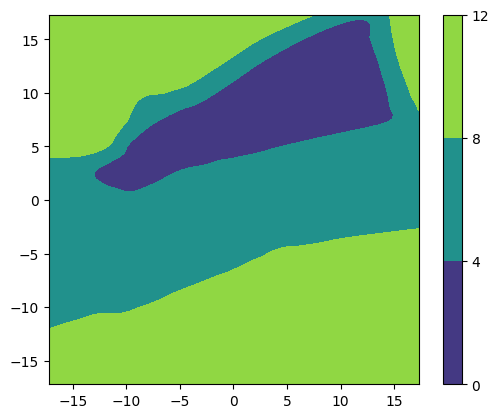

In [5]:
# Get contour
grid_x, grid_y = X_test.reshape(x_dim, y_dim, 2)[:, :, 0], X_test.reshape(x_dim, y_dim, 2)[:, :, 1]
grid_z = lengthscale_preds.reshape(x_dim, y_dim)
cs = plt.contourf(grid_x, grid_y, grid_z, levels=1)
plt.gca().set_aspect('equal')
plt.colorbar()

112 11200


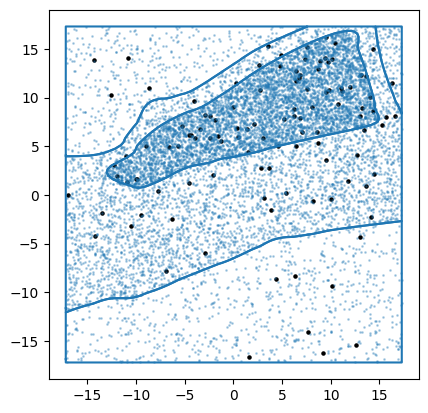

In [6]:
# Extract each polygon with holes from the contour map
polygons = []
levels = []
for contour_path, level in zip(cs.get_paths(), [2, 4, 8]): 
    for idx, cp in enumerate(contour_path.to_polygons()):
        x = cp[:,0]
        y = cp[:,1]
        polygon = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])

        if idx == 0:
            polygons.append(polygon)
            levels.append(level)
        else:
            if polygons[-1].intersects(polygon):
                # Remove holes
                polygons[-1] = polygons[-1].difference(polygon)
            else:
                # Save disjoint polygons
                polygons.append(polygon)
                levels.append(level)

sum_p = polygons[0]
for i in range(1, len(polygons)):
    sum_p = shapely.union(sum_p, polygons[i])

# Plot each polygon and sample points proportional to the lengthscale density of each polygon
pts_list = []
train_pts = []
num_train_pts = 10000
for l, p in zip(levels, polygons):
    x_ext, y_ext = p.exterior.xy
    plt.plot(x_ext, y_ext, c='C0')

    for interior in p.interiors:
        x_int, y_int = interior.xy
        plt.plot(x_int, y_int, color='C0')

    c_area = np.pi*((l/2)**2)
    size = int(np.ceil(p.area/c_area))
    pts = pointpats.random.poisson(p, size=size)
    t_pts = pointpats.random.poisson(p, size=size*100)

    if size == 1:
        pts_list.append([pts])
    else:
        pts_list.append(pts)
    train_pts.append(t_pts)

pts_list = np.concatenate(pts_list).astype(X_train.dtype)
train_pts = np.concatenate(train_pts).astype(X_train.dtype)
print(len(pts_list), len(train_pts))
plt.scatter(pts_list[:, 0], pts_list[:, 1], s=5, c='k')
plt.scatter(train_pts[:, 0], train_pts[:, 1], s=1, c='C0', alpha=0.3)
plt.gca().set_aspect('equal')
plt.show()

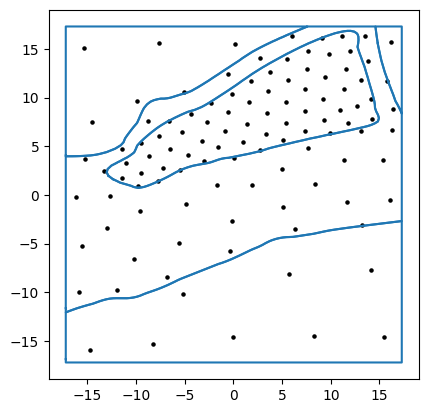

In [7]:
method = get_method('ContinuousSGP')
sp_optimizer = method(
    len(pts_list), 
    train_pts, 
    kernel,
    noise_variance, 
    X_init=pts_list.astype(X_train.dtype),
)

# 4. Run the optimization
X_sol = sp_optimizer.optimize()
X_sol = X_sol.reshape(-1, 2)

# Plot each polygon and solution points
for l, p in zip(levels, polygons):
    x_ext, y_ext = p.exterior.xy
    plt.plot(x_ext, y_ext, c='C0')

    for interior in p.interiors:
        x_int, y_int = interior.xy
        plt.plot(x_int, y_int, color='C0')

plt.scatter(X_sol[:, 0], X_sol[:, 1], s=5, c='k')
plt.gca().set_aspect('equal')
plt.show()

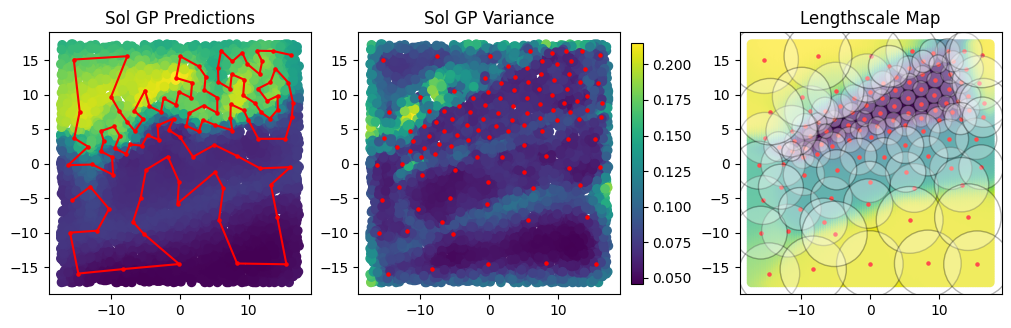

In [8]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)

mean, var = model_sol.predict_f(X_train)
sol_path, _ = run_tsp(X_sol, time_limit=10)
sol_lengthscales = predict_lengthscales(X_sol, lengthscales, kernel)


fig, axes = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_train[:, 0], X_train[:, 1], c=mean.numpy())
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_train[:, 0], X_train[:, 1], c=var.numpy())
axes[1].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# Third subplot — lengthscale
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=lengthscale_preds)
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[2].set_title("Lengthscale Map")
axes[2].set_aspect('equal')

for pt, d in zip(X_sol, sol_lengthscales):
    circle = patches.Circle(pt, 
                            d/2, 
                            edgecolor='k', 
                            facecolor='w', 
                            alpha=0.3)
    axes[2].add_patch(circle)

axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()